## Feedforward Neural Networks - MNIST Dataset

In [1]:
from Plot import plot_image_grid
from tqdm import tqdm
from tqdm.keras import TqdmCallback

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

## 🍳 Data Preparation

We'll be training on the MNIST dataset which has 60K images of handwritten numbers ranging from 0 to 9.

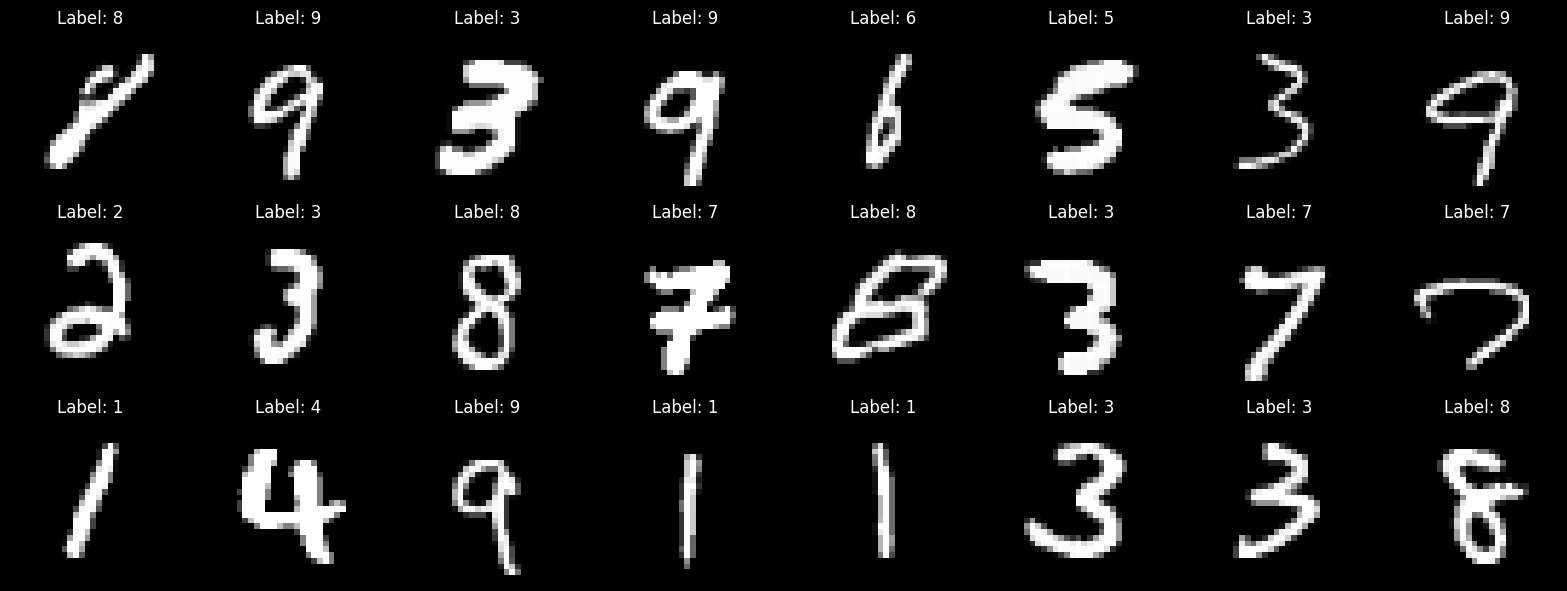

In [2]:
# Parameters
batch_size = 100

# Load the MNIST dataset
(x_train, y_train), (x_val, y_val) = keras.datasets.mnist.load_data()       # this yields it as a Numpy array

# Convert to tensor slices
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
plot_image_grid(train_dataset)

# Create batches
train_dataset_batched = train_dataset.batch(batch_size).shuffle(buffer_size=10000)
val_dataset_batched = val_dataset.batch(batch_size)

## 🚢 Model Building

In [106]:
from keras import layers, models, optimizers, losses

class NeuralNet(keras.Model):
    def __init__(self, input_shape, hidden_size, output_size, **kwargs):
        super(NeuralNet, self).__init__(**kwargs)
        
        # Architecture
        self.model = models.Sequential([
            keras.Input(shape=input_shape),
            layers.Permute((3, 1, 2)),                   # Permuting channels of the input image (needed for CNN layers: get used to it)
            layers.Flatten(),                             # Flattening the input
            layers.Dense(hidden_size),
            layers.Dropout(0.0),
            layers.ReLU(),
            layers.Dense(output_size)
        ])

    def call(self, inputs):
        logits = self.model(inputs)
        return logits

# Instantiate model
input_shape, hidden_size, output_size = (28, 28, 1), 500, 10
model = NeuralNet(input_shape = input_shape, hidden_size=hidden_size, output_size=output_size)
criterion = losses.SparseCategoricalCrossentropy(from_logits=True)              # integer representation of labels ≡ Sparse one-hot vectors
optimizer = optimizers.Adam(learning_rate=0.001)

In [107]:
model.summary()

Model: "neural_net_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_29 (Sequential)      │ ?                      │       397,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 397,510 (1.52 MB)

 Trainable params: 397,510 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

## 💪 Model Training

In [108]:
AddToClass = lambda func: setattr(NeuralNet, func.__name__, func) or func

@AddToClass
def train(self, train_dataset, num_epochs=300):
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        # 1. Setup metrics for epoch
        epoch_loss = keras.metrics.Mean()
        
        for x_batch, y_batch in train_dataset:
            # 2. Forward pass and compute loss
            with tf.GradientTape() as tape:
                y_pred = self(x_batch, training=True)
                loss = criterion(y_batch, y_pred)
            
            # 3. Backward pass
            gradients = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.trainable_variables))
            
            # 4. Update metrics
            epoch_loss.update_state(loss)
       
        pbar.set_description(f'Epoch {epoch + 1}, Loss: {round(float(epoch_loss.result()), 2)}')

model.train(train_dataset_batched, num_epochs=3)

Epoch 3, Loss: 0.29: 100%|██████████| 3/3 [00:25<00:00,  8.42s/it]


## 🕵️ Evaluation

Let's loop and test all validation data:

In [98]:
from keras.metrics import Accuracy

@AddToClass
def evaluate(self, val_dataset):
    # 1. Setup metrics
    Acc = Accuracy()
    for x_batch, y_batch in val_dataset:
        # 2. Forward pass
        y_pred = self(x_batch, training=False)
        y_pred_argmax = keras.ops.argmax(y_pred, axis=1)
        # 3. Update metrics
        Acc.update_state(y_batch, y_pred_argmax)
    return Acc.result().numpy()

model.evaluate(val_dataset_batched)

0.9548002

### ⭐ Equivalently

In [116]:
model = NeuralNet(input_shape = (28, 28, 1), hidden_size=500, output_size=10)
criterion = losses.SparseCategoricalCrossentropy(from_logits=True)              # integer representation of labels ≡ Sparse one-hot vectors
optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])
model.fit(train_dataset_batched, epochs=3, callbacks=[TqdmCallback()], verbose=False)
model.evaluate(val_dataset_batched)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9493 - loss: 0.5062


[0.41559234261512756, 0.9556000232696533]

### 💻 Deployment

In [135]:
model.save_weights("MNIST-Mode.weights.h5")

loaded_model = NeuralNet(input_shape = (28, 28, 1), hidden_size=500, output_size=10)
loaded_model.load_weights("MNIST-Mode.weights.h5")

<NeuralNet name=neural_net_41, built=False>

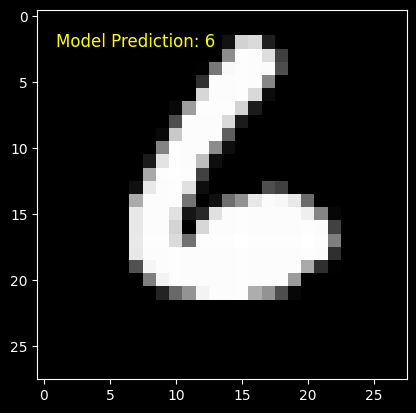

In [140]:
# random validation example
val_dataset_list = list(val_dataset.as_numpy_iterator())
rand_num = np.random.randint(len(val_dataset_list))
rand_val_img, _ = val_dataset_list[rand_num]
plt.imshow(rand_val_img, cmap='gray')
prediction = keras.ops.argmax(loaded_model(rand_val_img.reshape(1, 28, 28, 1)))
plt.text(0.05, 0.9, f'Model Prediction: {prediction}', color="yellow", transform=plt.gca().transAxes, fontsize=12)
plt.show()